# Heat Equation (معادله گرمایی)



معادله گرمایی یک‌بعدی با ضریب پخش حرارتی $\alpha = 0.4$ در دامنه $x \in [0,1]$ و بازه زمانی $t \in [0,1]$

$$
\frac{\partial u(x,t)}{\partial t} = \alpha \frac{\partial^2 u(x,t)}{\partial x^2}, \quad x \in [0,1], \; t \in [0,1] ; \alpha = 0.4
$$

---

#### 1. Boundary Conditions (شرایط مرزی)


شرایط مرزی به صورت زیر در نظر گرفته شده (مانند میله‌ای که دو سر آن در دمای صفر درجه قرار گرفته است):

$$
\begin{cases}
u(0,t) = 0 \\
u(1,t) = 0
\end{cases}
$$

---

#### 2. Initial Condition (شرط اولیه)


توزیع دمای اولیه به‌صورت تابع سینوسی با عدد مد $n$ داده شده است:

$$
u(x,0) = \sin\left( \frac{n\pi x}{L} \right), \quad 0 < x < L, \quad n = 1, 2, 3, \ldots
$$

---

#### 3. Analytical Solution (حل تحلیلی)


برای `L = 1` و `n = 1` پاسخ معادله دیفرانسیل به صورت زیر بیان می‌شود:

$$
u(x,t) = e^{-\frac{n^2 \pi^2 \alpha t}{L^2}} \sin\left( \frac{n\pi x}{L} \right)
$$


این جواب نشان می‌دهد که توزیع دما با گذر زمان به‌صورت نمایی کاهش می‌یابد، در حالی که شکل فضایی آن به صورت سینوسی باقی می‌ماند.

---
#### مشخصات ساختار شبکه عصبی مصنوعی
![Alt Text](../_static/images/PINN_3.png)


- اندازه لایه ورودی: 2
- تعداد لایه پنهان: 3
- تعداد نورن‌های لایه پنهان: 50
- اندازه لایه خروجی: 1
- تابع فعال ساز: tanh

## فراخوانی کتابخانه‌ها

#### تابع `torch.cuda.is_available()` در کتابخانه Pytorch:
- این تابع بررسی می‌کند که آیا سیستم به یک GPU دسترسی دارد یا نه. اگر  GPU توسط  PyTorch قابل استفاده باشد، مقدار `True` برمی‌گرداند، در غیر این صورت `False`.

In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Your device is using {device}")

Your device is using cuda


## ایجاد داده‌های آموزشی

#### تابع torch.meshgrid در PyTorch:
- تابعی است که دو بردار ورودی را گرفته و از آن‌ها شبکه‌ای دوبعدی از مختصات می‌سازد.
- `indexing ="ij"`: این دستور به این معنا است که ترتیب ماتریس‌ها به صورت `X[i,j]=x[i]` و `T[i,j]=t[j]` است.
- `indexing="xy"`: این دستور به این معنا است که ترتیب ماتریس‌ها به صورت `X[i,j]=x[j]` و `T[i,j]=t[i]` است.

#### تابع ravel() در کتابخانه PyTorch:
- ایت تابع تمامی مقادیر ماتریس `X` و `T` را به صورت یک ماتریس تخت یا به صورت یک بردار تبدیل می‌کند.
#### تابع vstack() در کتابخانه PyTorch:
- این تابع دو تانسور را به صورت عمودی بهم می‌چسباند.
#### دستور `to(device)` در کتابخانه PyTorch:
- این دستور بسته به مقدار `device` تانسور‌ها را به `CPU` یا `GPU` اجرا می‌کند.


In [22]:
domain = (0, 1)
n_train = 5


x = torch.linspace(domain[0], domain[1], n_train)
t = torch.linspace(domain[0], domain[1], n_train)
x.requires_grad = True
t.requires_grad = True 
# print(x)
# print(t)

X, T = torch.meshgrid((x, t), indexing="ij")
# print(X)
# print(T)
# print(X.ravel())
# print(T.ravel())
points = torch.vstack([X.ravel(), T.ravel()])
# print(points)
points = points.T.to(device)
print(points)


tensor([[0.0000, 0.0000],
        [0.0000, 0.2500],
        [0.0000, 0.5000],
        [0.0000, 0.7500],
        [0.0000, 1.0000],
        [0.2500, 0.0000],
        [0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.2500, 1.0000],
        [0.5000, 0.0000],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.5000, 1.0000],
        [0.7500, 0.0000],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500],
        [0.7500, 1.0000],
        [1.0000, 0.0000],
        [1.0000, 0.2500],
        [1.0000, 0.5000],
        [1.0000, 0.7500],
        [1.0000, 1.0000]], device='cuda:0', grad_fn=<ToCopyBackward0>)


## ایجاد شبکه عصبی مصنوعی

In [23]:
torch.manual_seed(42)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l4(out)
        return out
        
input_size, hidden_size, output_size = 2, 50, 1
model = NeuralNet(input_size, hidden_size, output_size)

model.to(device)

NeuralNet(
  (l1): Linear(in_features=2, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=50, bias=True)
  (l3): Linear(in_features=50, out_features=50, bias=True)
  (l4): Linear(in_features=50, out_features=1, bias=True)
  (tanh): Tanh()
)

## الگوریتم بهینه سازی

In [24]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## مشتق‌گیری از خروجی‌های شبکه عصبی

#### توضیح درباره خروجی‌های `torch.autograd.grad`

تابع `torch.autograd.grad(outputs, inputs)` گرادیان خروجی‌ها را نسبت به ورودی‌ها محاسبه می‌کند و یک لیست از تانسورها باز می‌گرداند. در اینجا، ما از `[0]` برای دسترسی به اولین (و تنها) عنصر این لیست استفاده می‌کنیم.

#### ۱. وقتی از `[:, 0:1]` و `[:, 1:2]` استفاده می‌کنیم:

- `[:, 0:1]`: این عبارت مشتق `u` را نسبت به `x` (اولین ستون از ورودی‌ها) محاسبه می‌کند.
- `[:, 1:2]`: این عبارت مشتق `u` را نسبت به `t` (دومین ستون از ورودی‌ها) محاسبه می‌کند.

#### ۲. وقتی از `[:, :]` استفاده نکنیم:

اگر از `[:, :]` یا بدون هیچ ‌زیر مجموعه انتخابی استفاده کنیم، تمام مقادیر گرادیان‌ها (برای هر دو بعد `x` و `t`) را به عنوان یک تانسور بدون جدا کردن آن‌ها دریافت خواهیم کرد. به عبارت دیگر، خروجی مشتق دوم شامل تمام مشتقات نسبت به تمام متغیرهای ورودی می‌شود.
$$
\frac{\partial^2 u}{\partial (\text{inputs})^2} =
\begin{bmatrix}
\displaystyle
\frac{\partial}{\partial x}\Bigl(\frac{\partial u}{\partial x} + \frac{\partial u}{\partial t}\Bigr) &
\displaystyle
\frac{\partial}{\partial t}\Bigl(\frac{\partial u}{\partial x} + \frac{\partial u}{\partial t}\Bigr)
\end{bmatrix}
=\begin{bmatrix}
u_{xx} + u_{tx} & u_{xt} + u_{tt}
\end{bmatrix}.
$$



In [25]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

# points.requires_grad = True
print(f"inputs: {points}\n")


u = model(points)
print(f"outputs: {u}\n")
dudx = grad(u, points)[:, 0:1]
print(f"the derivative of u with respect to x:{dudx}\n")
d2udx2 = grad(dudx, points)[:, 0:1]
print(f"the second derivative of u with respect to x:{d2udx2}\n")
dudt = grad(u, points)[:, 1:2]
# print(f"the derivative of u with respect to t:{dudt}")

inputs: tensor([[0.0000, 0.0000],
        [0.0000, 0.2500],
        [0.0000, 0.5000],
        [0.0000, 0.7500],
        [0.0000, 1.0000],
        [0.2500, 0.0000],
        [0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.2500, 1.0000],
        [0.5000, 0.0000],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.5000, 1.0000],
        [0.7500, 0.0000],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500],
        [0.7500, 1.0000],
        [1.0000, 0.0000],
        [1.0000, 0.2500],
        [1.0000, 0.5000],
        [1.0000, 0.7500],
        [1.0000, 1.0000]], device='cuda:0', grad_fn=<ToCopyBackward0>)

outputs: tensor([[0.0611],
        [0.0672],
        [0.0744],
        [0.0825],
        [0.0913],
        [0.0569],
        [0.0617],
        [0.0678],
        [0.0751],
        [0.0835],
        [0.0546],
        [0.0582],
        [0.0633],
        [0.0698],
        [0.0777],
        [0.0541],

## تابع هزینه مسئله معادله گرما

در این مسئله معادله‌ی زیر را داشتیم:

$$
\frac{\partial u}{\partial t} - 0.4 \frac{\partial^2 u}{\partial x^2} = 0
$$

---

#### بخش‌های مختلف تابع هزینه (Loss Terms):

- **L_phy**: این بخش به معادله دیفرانسیل اصلی مربوط می‌شود

$$
L_{phy} = W_1 \frac{1}{N} \sum_{i=1}^{N} \left(\frac{\partial u_i}{\partial t_i} - 0.4 \frac{\partial^2 u_i}{\partial x_i^2}\right)^2
$$

- **L_BC1**: در شرایط مرزی \( x=0 \) مقدار تابع باید صفر باشد

$$
L_{BC1} = \frac{1}{K} \sum_{i=1}^{K} (u_i(x=0, t_i) - 0)^2
$$

- **L_BC2** : در شرایط مرزی \( x=1 ) مقدار تابع باید صفر باشد:

$$
L_{BC2} = \frac{1}{K} \sum_{i=1}^{K}(u_i(x=1, t_i) - 0)^2
$$

- **L_BCs** : ترکیب دو شرط مرزی بالا برای نقاط \( x = 0 \) و \( x = 1 \):

$$
L_{BCs} = W_2\frac{1}{(2K)} \sum_{i=1}^{(2K)} u_i(x, t_i)^2 \quad \text{for} \; x=0 \; \& \; x=1
$$

- **L_IC** : شرط اولیه برای زمان \( t = 0 \) به صورت تابع سینوسی زیر است:

$$
L_{IC} = W_3\frac{1}{K} \sum_{i=1}^{K} (u_i(x_i, t=0) - \sin(\pi x_i))^2
$$

  🔺 در اینجا باید فقط نقاطی که در آن t = 0 هستند باید انتخاب شوند، یعنی نقاطی مانند (x, t=0) مجاز هستند، ولی نقاطی مانند (x, t=0.1) مجاز نیستند.
  
✅ نمونه مجاز: (0.5, 0)

❌ نمونه غیر مجاز: (0.5, 1)

- **تابع نهایی هزینه (Loss)**:

$$
\text{Loss} = L_{\text{phy}} + L_{\text{BC1}} + L_{\text{BC2}}
$$

#### ایجاد نقاط مرزی

- ‍‍`points[:, 0] == 0`: این دستور تمامی نقاطی را که مقدار `x` برابر صفر است استخراج میکند. این تابع یک لیست به صورت `Boolean` بر میگرداند که در آن نقاطی که در شرط مورد نظر صدق می‌کنند `True` است.
- `points[:, 0] == 1)`: این دستور تمامی نقاطی را که مقدار `x` برابر یک است استخراج میکند. این تابع یک لیست به صورت `Boolean` بر میگرداند که در آن نقاطی که در شرط مورد نظر صدق می‌کنند `True` است.
- `points[:, 1] == 0)`: این دستور تمامی نقاطی را که مقدار `t` برابر صفر است استخراج میکند. این تابع یک لیست به صورت `Boolean` بر میگرداند که در آن نقاطی که در شرط مورد نظر صدق می‌کنند `True` است.
- `nonzero(as_tuple=True)`: این دستور اندیس نقاطی که شرایط برای آنها برقرار است را به صورت `tuple` بر میگرداند
  - خروجی این دستور شامل دو موولفه است که دومین مولفه خالی است و اولین مولفه شامل لیستی از اندیس‌ها است.
- ‍‍`torch.cat([indices1, indices2])`: این دستور برای چسباندن دو تانسور به کار می‌رود که اندیس‌های مرز چپ و مرز راست را با یکدیگر ترکیب می‌کند تا تمام نقاط مرزی به دست آید.

In [6]:
indices1 = (points[:, 0]==0).nonzero(as_tuple=True)[0]
indices2 = (points[:, 0]==1).nonzero(as_tuple=True)[0]
indices3 = (points[:, 1]==0).nonzero(as_tuple=True)[0]
indices12 = torch.cat([indices1, indices2])
def loss_fn(u, d2udx2, dudt, points, indices12, indices3, weights):
    w1, w2, w3 = weights
    L_phy = w1*torch.mean((dudt - 0.4*d2udx2)**2)
    L_IC = w2*torch.mean((u[indices3] - torch.sin(torch.pi*points[indices3, 0:1]))**2)
    L_BC = w3*torch.mean((u[indices12])**2)
    loss = L_phy + L_BC + L_IC
    return loss, L_phy, L_BC, L_IC

## آموزش شبکه عصبی

In [7]:
num_itrs = 2000
itr_show = 100
weights = (1, 1, 1)

L_total_history = []
L_phy_history = []
L_BC_history = []
L_IC_history = []

pbar = trange(num_itrs)
for itr in pbar:
    u = model(points)
    dudx = grad(u, points)[:, 0:1]
    d2udx2 = grad(dudx, points)[:, 0:1]
    dudt = grad(u, points)[:, 1:2]

    loss, L_phy, L_BC, L_IC = loss_fn(u, d2udx2, dudt, points, indices12, indices3, weights)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    L_total_history.append(loss.item())
    L_phy_history.append(L_phy.item())
    L_BC_history.append(L_BC.item())
    L_IC_history.append(L_IC.item())
    
    pbar.set_postfix({'loss': loss.item()})
    # if itr % itr_show == 0:
    #     print(f'iteration {itr}/{num_itrs}, loss = {loss.item():.6f}')


100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 57.30it/s, loss=1.21e-5]


## بهره‌برداری از شبکه عصبی مصنوعی

- `.view(n_test, n_test)`: از انجایی که داده‌های خروجی در قالب یک بردار یک بعدی هستند برای رسم دو بعدی باید به شکل (n_test, n_test) بازآرایی کرد. اینکار باعث می‌شود داده‌های در شبکه‌ای مقادیر `x` و `t` قابل ترسیم باشند.

- `plt.contourf()`: ما تابع مدل را در صفحه‌ی (x, t) محاسبه کرده‌ایم. با استفاده از `plt.contourf` می‌توانیم توزیع این تابع را در زمان‌ها و مکان‌های مختلف ببینیم.


MSE error: 1.2524047633633018e-05


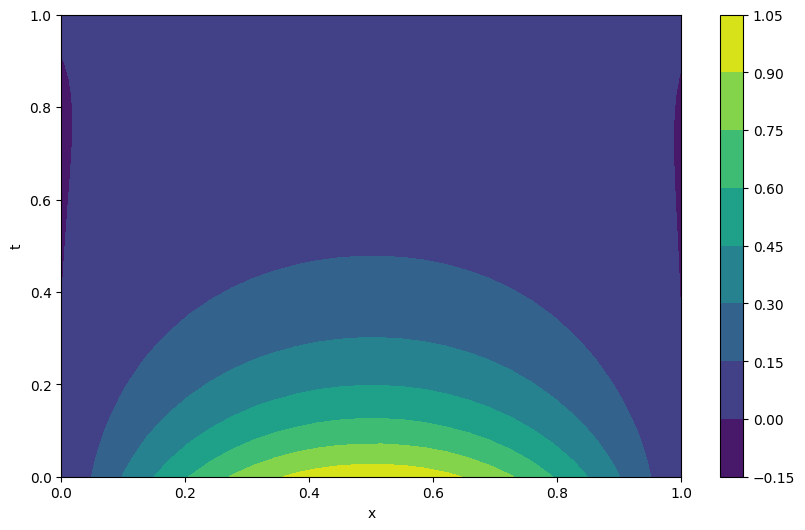

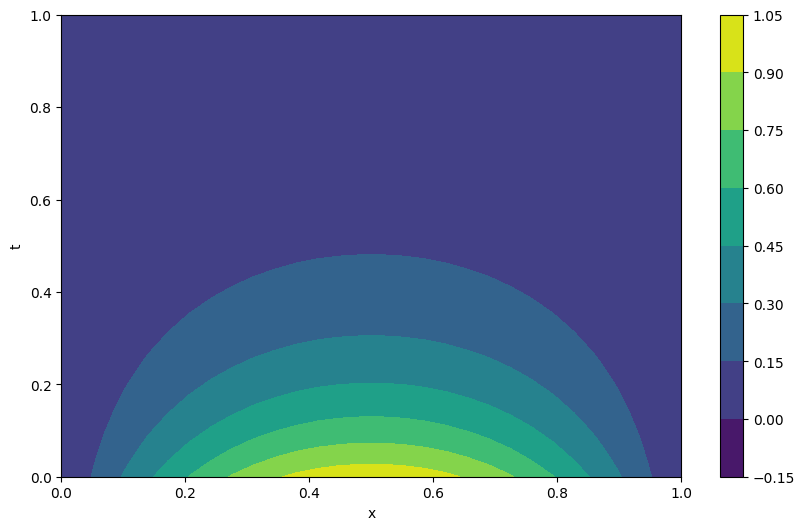

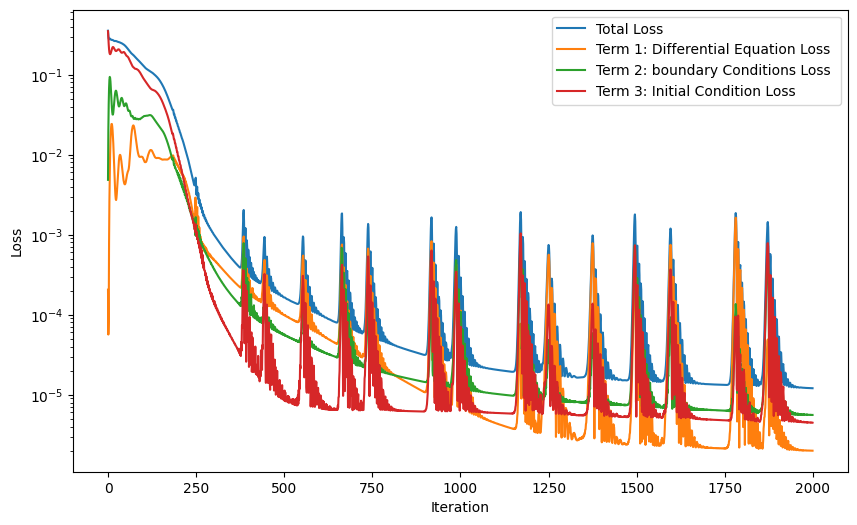

In [8]:
n_test = 30
def exact_solution(points):
    x, t = points[:, 0:1], points[:, 1:2]
    return torch.exp(-0.4*(torch.pi**2)*t) * torch.sin(torch.pi*x)
    
t = torch.linspace(domain[0], domain[1], n_test)
x = torch.linspace(domain[0], domain[1], n_test)

X, T = torch.meshgrid((x, t), indexing="ij")
points = torch.vstack([X.ravel(), T.ravel()]).T.to(device)


predicted = model(points)

analytic_cal = exact_solution(points)

mse = torch.mean((predicted - analytic_cal)**2)
print(f"MSE error: {mse}")

predicted = predicted.view(n_test, n_test)
analytic_cal = analytic_cal.view(n_test, n_test)

plt.figure(figsize=(10, 6))
cp = plt.contourf(X.detach().numpy(), T.detach().numpy(), predicted.cpu().detach().numpy())
plt.colorbar(cp)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(10, 6))
cp = plt.contourf(X.detach().numpy(), T.detach().numpy(), analytic_cal.cpu().detach().numpy())
plt.colorbar(cp)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(10, 6))
plt.semilogy(L_total_history, label="Total Loss")
plt.semilogy(L_phy_history, label="Term 1: Differential Equation Loss")
plt.semilogy(L_BC_history, label="Term 2: boundary Conditions Loss ")
plt.semilogy(L_IC_history, label="Term 3: Initial Condition Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## پیاده‌سازی نهایی

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Your device is using {device}")

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l4(out)
        return out


class Trainer:
    def __init__(self, model, optimizer, domain, weights):
        self.model = model
        self.optimizer = optimizer
        self.domain = domain
        self.weights = weights

        self.L_total_history = []
        self.L_phy_history = []
        self.L_BC_history = []
        self.L_IC_history = []

    def exact_solution(self, points):
        x, t = points[:, 0:1], points[:, 1:2]
        return torch.exp(-0.4*(torch.pi**2)*t) * torch.sin(torch.pi*x)

    def grad(self, outputs, inputs):
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

    def generate_data(self, n_data):
        t = torch.linspace(self.domain[0], self.domain[1], n_data)
        x = torch.linspace(self.domain[0], self.domain[1], n_data)
        
        X, T = torch.meshgrid((x, t), indexing="ij")
        data = torch.vstack([X.ravel(), T.ravel()]).T.to(device)
        
        return X, T, data

    def loss_fn(self, u, d2udx2, dudt, points, indices12, indices3, weights):
        w1, w2, w3 = weights
        L_phy = w1*torch.mean((dudt - 0.4*d2udx2)**2)
        L_IC = w2*torch.mean((u[indices3] - torch.sin(torch.pi*points[indices3, 0:1]))**2)
        L_BC = w3*torch.mean((u[indices12])**2)
        loss = L_phy + L_BC + L_IC
        return loss, L_phy, L_BC, L_IC

    def train(self, n_train, num_itr, show_itr=False):

        
        X, T, points = self.generate_data(n_train)
        points.requires_grad = True


        indices1 = (points[:, 0]==0).nonzero(as_tuple=True)[0]
        indices2 = (points[:, 0]==1).nonzero(as_tuple=True)[0]
        indices3 = (points[:, 1]==0).nonzero(as_tuple=True)[0]
        indices12 = torch.cat([indices1, indices2])

        
        pbar = trange(num_itr)
        for itr in pbar:
            u = model(points)
            dudx = self.grad(u, points)[:, 0:1]
            d2udx2 = self.grad(dudx, points)[:, 0:1]
            dudt = self.grad(u, points)[:, 1:2]
        
            loss, L_phy, L_BC, L_IC = self.loss_fn(u, d2udx2, dudt, points, indices12, indices3, weights)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            self.L_total_history.append(loss.item())
            self.L_phy_history.append(L_phy.item())
            self.L_BC_history.append(L_BC.item())
            self.L_IC_history.append(L_IC.item())
        
            
            if show_itr and itr % 100 == 0:
                print(f'iteration {itr}/{num_itr}, loss = {loss.item():.6f}')
            else:
                pbar.set_postfix({'loss': loss.item()})


    def evaluation(self, n_test):
        X, T, points = self.generate_data(n_test)

        predicted = self.model(points)
        
        analytic_cal = self.exact_solution(points)
        
        mse = torch.mean((predicted - analytic_cal)**2)
        print(f"MSE error: {mse}")
        
        predicted = predicted.view(n_test, n_test)
        analytic_cal = analytic_cal.view(n_test, n_test)
        
        plt.figure(figsize=(10, 6))
        cp = plt.contourf(X.detach().numpy(), T.detach().numpy(), predicted.cpu().detach().numpy())
        plt.colorbar(cp)
        plt.xlabel('x')
        plt.ylabel('t')
        plt.show()
        
        plt.figure(figsize=(10, 6))
        cp = plt.contourf(X.detach().numpy(), T.detach().numpy(), analytic_cal.cpu().detach().numpy())
        plt.colorbar(cp)
        plt.xlabel('x')
        plt.ylabel('t')
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.semilogy(self.L_total_history, label="Total Loss")
        plt.semilogy(self.L_phy_history, label="Term 1: Differential Equation Loss")
        plt.semilogy(self.L_BC_history, label="Term 2: boundary Conditions Loss")
        plt.semilogy(self.L_IC_history, label="Term 3: Initial Condition Loss")
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


Your device is using cuda


100%|████████████████████████████████████████████████████████████████| 5000/5000 [01:20<00:00, 61.82it/s, loss=1.44e-5]


MSE error: 2.189112137784832e-06


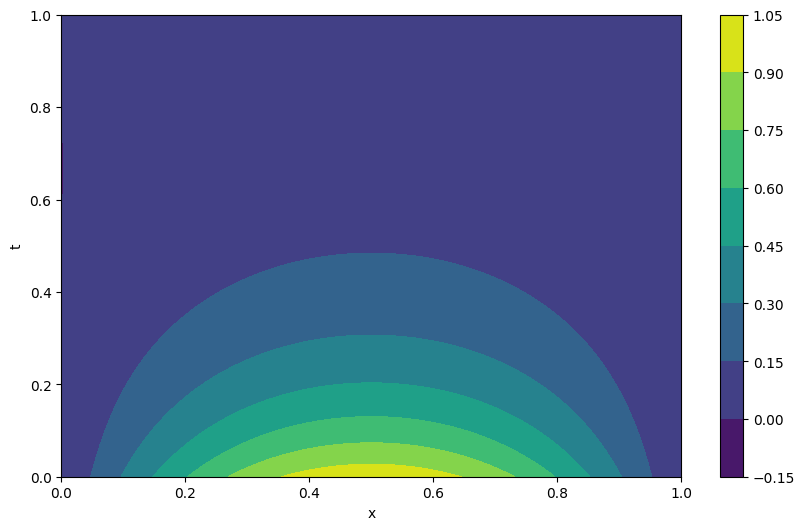

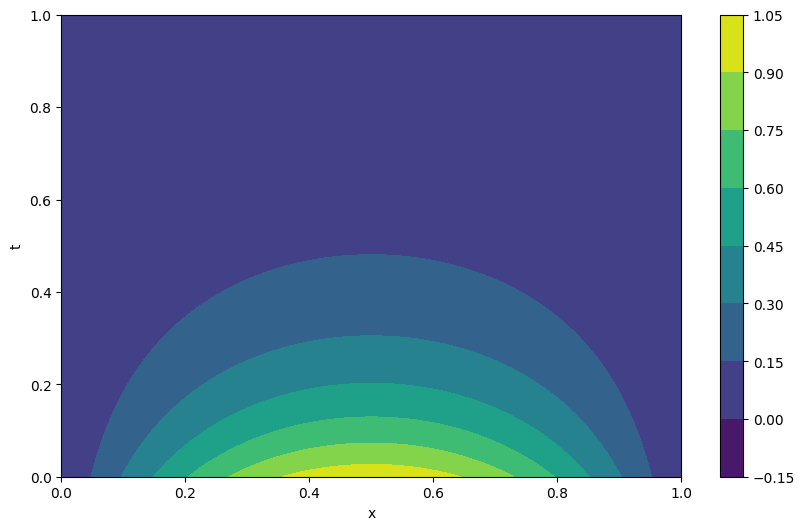

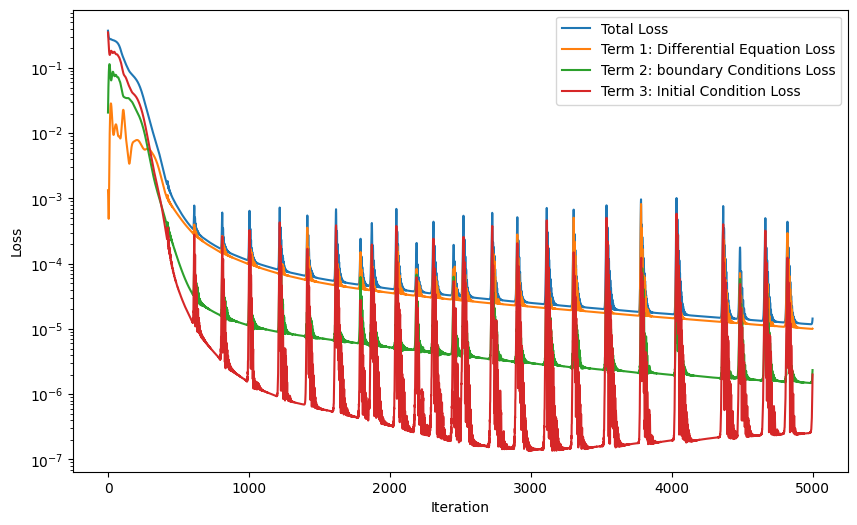

In [10]:
torch.manual_seed(42)
n_train, n_test, num_itr, itr_show = 30, 100, 5000, 1000
weights, domain = (1, 1, 1), (0, 1)
learning_rate = 0.001
input_size, hidden_size, output_size = 2, 30, 1

model = NeuralNet(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainer = Trainer(model, optimizer, domain, weights)

trainer.train(n_train, num_itr, show_itr=False)

trainer.evaluation(n_test)

# معادله لاپلاس بر روی یک دیسک 

حل معادله لاپلاس در ناحیه‌ای به شکل دیسک واحد با استفاده از شبکه‌های عصبی فیزیک‌مبنا (PINNs):

$$
\nabla^2 u(r, \theta) = \frac{\partial^2 u}{\partial r^2} + \frac{1}{r} \frac{\partial u}{\partial r} + \frac{1}{r^2} \frac{\partial^2 u}{\partial \theta^2} = 0, \quad r \in [0,1], \; \theta \in [0, 2\pi]
$$

---

#### 1. شرط مرزی اول

مقدار تابع $u$ روی مرز دیسک (برای $r=1$) به صورت زیر داده شده است:

$$
u(1, \theta) = \cos(2\theta)
$$

---

#### 2. شرط مرزی دوم
$$
u(r, \theta + 2\pi) = u(r, \theta)
$$

---

#### 3. حل تحلیلی

حل تحلیلی معادله لاپلاس برای این شرایط مرزی در دستگاه مختصات قطبی به صورت زیر است:

$$
u(r, \theta) = r^2 \cos(2\theta)
$$

---

#### 4. مشخصات ساختار شبکه عصبی مصنوعی  
![Alt Text](../_static/images/PINN_4.png)

- اندازه لایه ورودی: 2 (مختصات $r$ و $\theta$)  
- تعداد لایه پنهان: ۳  
- تعداد نورون‌های لایه پنهان: ۵۰  
- اندازه لایه خروجی: ۱  
- تابع فعال‌ساز: $\tanh$


## فراخوانی کتابخانه‌ها

In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Your device is using {device}")

Your device is using cuda


## ایجاد داده‌های آموزشی برای آموزش شبکه عصبی مصنوعی

In [12]:
domain1 = (0, 2*torch.pi) # theta
domain2 = (0, 1) # r
n_train = 30
t = torch.linspace(domain1[0], domain1[1], n_train)
r = torch.linspace(domain2[0], domain2[1], n_train)
R, T = torch.meshgrid((r, t), indexing="ij")
points = torch.vstack([R.ravel(), T.ravel()]).T.to(device)

## ایجاد شبکه عصبی و الگوریتم بهینه‌سازی

In [13]:
torch.manual_seed(42)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l4(out)
        return out
        
input_size, hidden_size, output_size = 2, 50, 1
model = NeuralNet(input_size, hidden_size, output_size).to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## مشتق‌گیری از خروجی‌های شبکه عصبی

In [14]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    
points.requires_grad = True
u = model(points)

dudr = grad(u, points)[:, 0:1]
d2udr2 = grad(dudr, points)[:, 0:1]
dudt = grad(u, points)[:, 1:2]
d2udt2 = grad(dudt, points)[:, 1:2]

## تابع هزینه برای حل معادله لاپلاس بر روی یک دیسک (در مختصات قطبی)

در این مسئله، معادله‌ی لاپلاس در مختصات قطبی به صورت زیر داده شده است:

$$
r \frac{\partial u}{\partial r} + r^2 \frac{\partial^2 u}{\partial r^2} + \frac{\partial^2 u}{\partial \theta^2} = 0
$$

---

#### بخش‌های مختلف تابع هزینه (Loss Terms):

- **L_phy**: این بخش به معادله دیفرانسیل اصلی مربوط می‌شود

$$
L_{\text{phy}} = W_1 \cdot \frac{1}{N} \sum_{i=1}^{N} \left( r_i \cdot \frac{\partial u_i}{\partial r_i} + r_i^2 \cdot \frac{\partial^2 u_i}{\partial r_i^2} + \frac{\partial^2 u_i}{\partial \theta_i^2} \right)^2
$$

- **L_BC1**: در شرایط مرزی مقادیر تابع در (r=1) باید برابر $cos(\theta)$ باشد:

$$
L_{\text{BC1}} = W_2 \cdot \frac{1}{K} \sum_{i=1}^{K} \left(u_i(r=1, \theta_i) - \cos(\theta_i)\right)^2
$$

- **L_BC2**: در شرایط مرزی دوره‌ای مقادیر تابع برای نقاطی که در آنها $\theta=0$ و $\theta=2\pi$ است باید با یکدیگر برابر باشد

$$
L_{\text{BC2}} = W_3 \cdot \frac{1}{K} \sum_{i=1}^{K} \left(u_i(r_i, \theta=2\pi) - u_i(r_i, \theta=0)\right)^2
$$

- **تابع نهایی هزینه (Loss)**:

$$
\text{Loss} = L_{\text{phy}} + L_{\text{BC1}} + L_{\text{BC2}}
$$




In [15]:
indices1 = (points[:, 0]==1).nonzero(as_tuple=True)[0].to(device)
indices2 = (points[:, 1]==2*torch.pi).nonzero(as_tuple=True)[0].to(device)
indices3 = (points[:, 1]==0).nonzero(as_tuple=True)[0].to(device)

def loss_fn(u, dudr, d2udr2, d2udt2, points, indices1, indices2, indices3, weights):
    w1, w2, w3 = weights

    L_phy = w1*torch.mean((points[:, 0:1]*dudr + (points[:, 0:1]**2)*d2udr2 + d2udt2)**2)
    L_BC1 = w2*torch.mean((u[indices1] - torch.cos(points[indices1, 1:2]))**2)
    L_BC2 = w3*torch.mean((u[indices2] - u[indices3])**2)
    loss = L_phy + L_BC1 + L_BC2
    
    return loss, L_phy, L_BC1, L_BC2

## آموزش شبکه عصبی

In [16]:
num_itrs = 2000
itr_show = 100
weights = (1, 1, 1)



L_total_history = []
L_phy_history = []
L_BC1_history = []
L_BC2_history = []

pbar = trange(num_itrs)
for itr in pbar:
    u = model(points)
    
    dudr = grad(u, points)[:, 0:1]
    d2udr2 = grad(dudr, points)[:, 0:1]
    dudt = grad(u, points)[:, 1:2]
    d2udt2 = grad(dudt, points)[:, 1:2]
    
    loss, L_phy, L_BC1, L_BC2 = loss_fn(u, dudr, d2udr2, d2udt2, points, indices1, indices2, indices3, weights)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    L_total_history.append(loss.item())
    L_phy_history.append(L_phy.item())
    L_BC1_history.append(L_BC1.item())
    L_BC2_history.append(L_BC2.item())
    
    pbar.set_postfix({'loss': loss.item()})
    # if itr % itr_show == 0:
    #     print(f'iteration {itr}/{num_itrs}, loss = {loss.item():.6f}')


100%|█████████████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 48.30it/s, loss=0.0012]


## بهره‌برداری از شبکه عصبی مصنوعی

MSE error: 0.0494583323597908


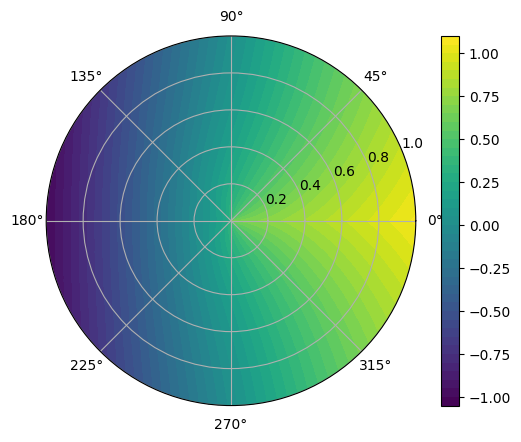

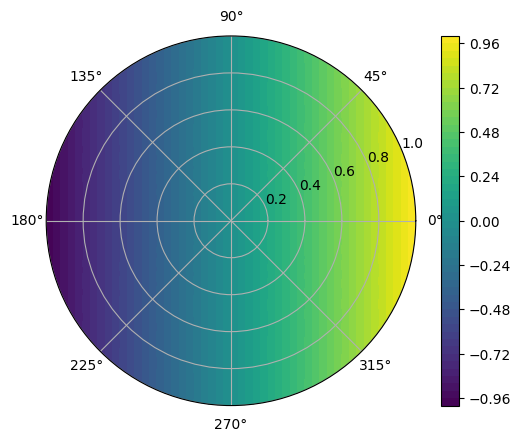

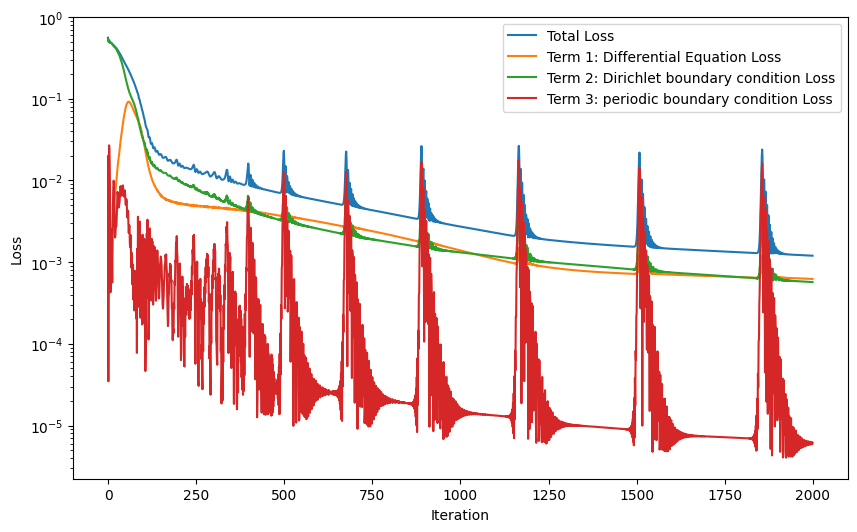

In [17]:
n_test = 50

def exact_solution(points):
    r, t = points[:, 0:1], points[:, 1:2]
    return r*torch.cos(t)

t = torch.linspace(domain1[0], domain1[1], n_test)
r = torch.linspace(domain2[0], domain2[1], n_test)
R, T = torch.meshgrid((r, t), indexing="ij")
data = torch.vstack([R.ravel(), T.ravel()]).T


predicted = model(data.to(device))
analytic_cal = exact_solution(data).to(device)

mse = torch.mean((predicted - analytic_cal)**2)
print(f"MSE error: {mse}")

predicted = predicted.view(n_test, n_test)
analytic_cal = analytic_cal.view(n_test, n_test)

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.contourf(T.detach().numpy(), R.detach().numpy(), predicted.cpu().detach().numpy(), 50, cmap='viridis')
fig.colorbar(c)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.contourf(T.detach().numpy(), R.detach().numpy(), analytic_cal.cpu().detach().numpy(), 50, cmap='viridis')
fig.colorbar(c)
plt.show()

plt.figure(figsize=(10, 6))
plt.semilogy(L_total_history, label="Total Loss")
plt.semilogy(L_phy_history, label="Term 1: Differential Equation Loss")
plt.semilogy(L_BC1_history, label="Term 2: Dirichlet boundary condition Loss")
plt.semilogy(L_BC2_history, label="Term 3: periodic boundary condition Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## پیاده‌سازی نهایی

In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Your device is using {device}")

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l4(out)
        return out


class Trainer:
    def __init__(self, model, optimizer, domain1, domain2, weights):
        self.model = model
        self.optimizer = optimizer
        self.domain1 = domain1
        self.domain2 = domain2
        self.weights = weights

        self.L_total_history = []
        self.L_phy_history = []
        self.L_BC1_history = []
        self.L_BC2_history = []

    def exact_solution(self, points):
        r, t = points[:, 0:1], points[:, 1:2]
        return r*torch.cos(t)

    def grad(self, outputs, inputs):
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

    def generate_data(self, n_data):
        t = torch.linspace(self.domain1[0], self.domain1[1], n_data)
        r = torch.linspace(self.domain2[0], self.domain2[1], n_data)
        R, T = torch.meshgrid((r, t), indexing="ij")
        data = torch.vstack([R.ravel(), T.ravel()]).T.to(device)
        return R, T, data

    def loss_fn(self, u, dudr, d2udr2, d2udt2, points, indices1, indices2, indices3, weights):
        w1, w2, w3 = weights
        L_phy = w1*torch.mean((points[:, 0:1]*dudr + (points[:, 0:1]**2)*d2udr2 + d2udt2)**2)
        L_BC1 = w2*torch.mean((u[indices1] - torch.cos(points[indices1, 1:2]))**2)
        L_BC2 = w3*torch.mean((u[indices2] - u[indices3])**2)
        loss = L_phy + L_BC1 + L_BC2
        return loss, L_phy, L_BC1, L_BC2

    def train(self, n_train, num_itr, show_itr=False):

        
        R, T, points = self.generate_data(n_train)
        points.requires_grad = True


        indices1 = (points[:, 0]==1).nonzero(as_tuple=True)[0].to(device)
        indices2 = (points[:, 1]==2*torch.pi).nonzero(as_tuple=True)[0].to(device)
        indices3 = (points[:, 1]==0).nonzero(as_tuple=True)[0].to(device)

        pbar = trange(num_itr)
        for itr in pbar:
            u = self.model(points)

            dudr = self.grad(u, points)[:, 0:1]
            d2udr2 = self.grad(dudr, points)[:, 0:1]
            dudt = self.grad(u, points)[:, 1:2]
            d2udt2 = self.grad(dudt, points)[:, 1:2]
            
            loss, L_phy, L_BC1, L_BC2 = self.loss_fn(u, dudr, d2udr2, d2udt2, points, indices1, indices2, indices3, weights)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            self.L_total_history.append(loss.item())
            self.L_phy_history.append(L_phy.item())
            self.L_BC1_history.append(L_BC1.item())
            self.L_BC2_history.append(L_BC2.item())
        

            if show_itr and itr % 100 == 0:
                print(f'iteration {itr}/{num_itr}, loss = {loss.item():.6f}')
            else:
                pbar.set_postfix({'loss': loss.item()})


    def evaluation(self, n_test):
        R, T, points = self.generate_data(n_test)
        predicted = self.model(points.to(device))
        analytic_cal = self.exact_solution(points).to(device)
        
        mse = torch.mean((predicted - analytic_cal)**2)
        print(f"MSE error: {mse}")

        predicted = predicted.view(n_test, n_test)
        analytic_cal = analytic_cal.view(n_test, n_test)
        
        fig = plt.figure()
        ax = fig.add_subplot(111, polar=True)
        c = ax.contourf(T.detach().numpy(), R.detach().numpy(), predicted.cpu().detach().numpy(), 100,cmap='viridis')
        fig.colorbar(c)
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111, polar=True)
        c = ax.contourf(T.detach().numpy(), R.detach().numpy(), analytic_cal.cpu().detach().numpy(), 100,cmap='viridis')
        fig.colorbar(c)
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.semilogy(self.L_total_history, label="Total Loss")
        plt.semilogy(self.L_phy_history, label="Term 1: Differential Equation Loss")
        plt.semilogy(self.L_BC1_history, label="Term 2: Dirichlet boundary condition Loss")
        plt.semilogy(self.L_BC2_history, label="Term 3: periodic boundary condition Loss")
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


Your device is using cuda


100%|████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.52it/s, loss=0.00111]


MSE error: 0.01583779789507389


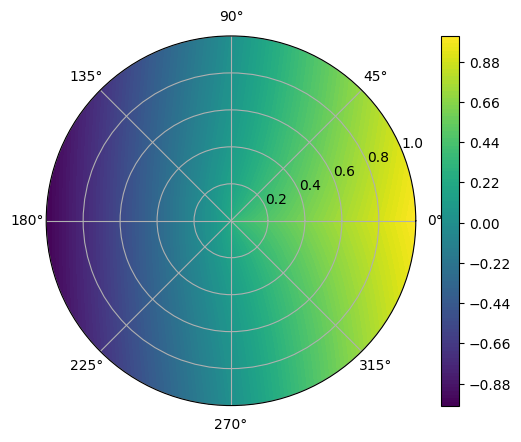

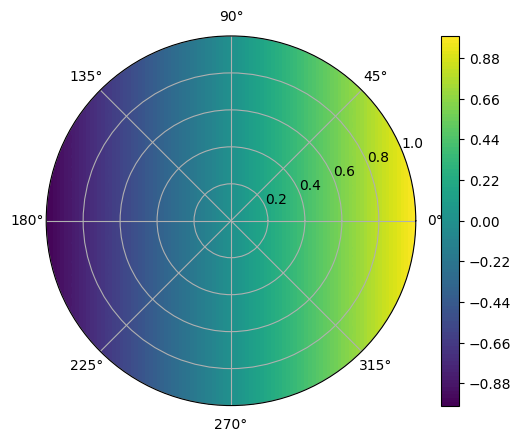

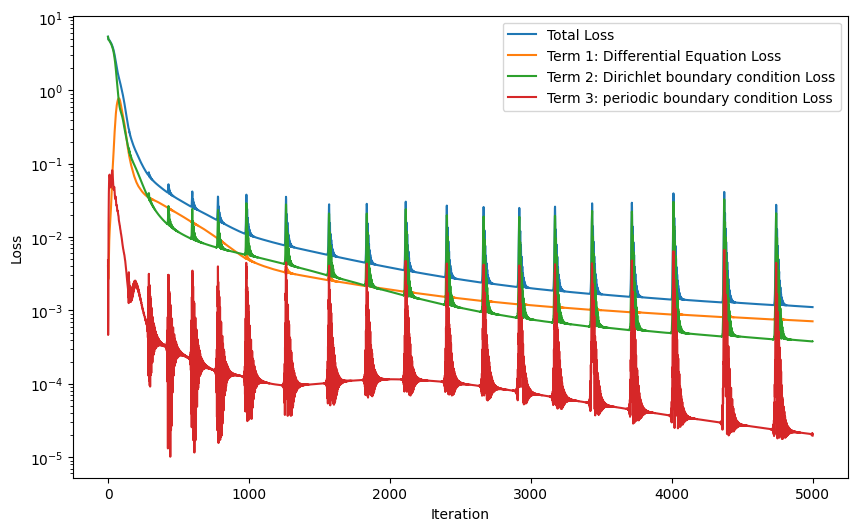

In [19]:
torch.manual_seed(42)
n_train, n_test, num_itr, itr_show = 30, 100, 5000, 1000
weights, domain1, domain2 = (5, 10, 1), (0, 2*torch.pi), (0, 1)
learning_rate = 0.001
input_size, hidden_size, output_size = 2, 30, 1

model = NeuralNet(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trainer = Trainer(model, optimizer, domain1, domain2, weights)

trainer.train(n_train, num_itr, show_itr=False)

trainer.evaluation(n_test)